In [1]:
import matplotlib.pyplot as plt
import torch as t
import torch
import einops

In [2]:
"""
display img with dimensions figsize
img is a np.array or tensor of shape [1, 3, H, W] or [3, H, W]
"""
def imshow(img, figsize=(6,6)):
    plt.figure(figsize=figsize)
    if len(img.shape) == 4: img = img.squeeze(0)
    if img.size(2) != 3: img = einops.rearrange(img, 'c h w -> h w c', c = 3)
    plt.axis("off")
    plt.imshow(img.detach())


In [3]:
import torchvision 
model = torchvision.models.resnet34(pretrained=True)
model.eval();

# Image parameterization 1

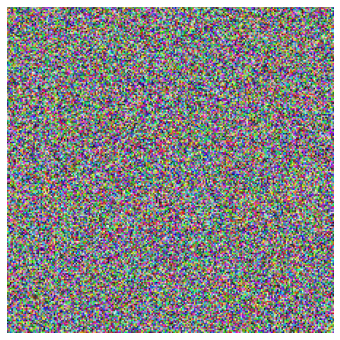

In [108]:
from torch.nn import Module, Parameter

class Img(Module):
    def __init__(self, C = 3, H=224, W=224):
        super().__init__()
        self.img = Parameter(t.rand(1, C, H, W))

    def forward(self):
        return t.clip(self.img, min=0., max=1.)
        
imshow(Img()(),figsize=(6,6))

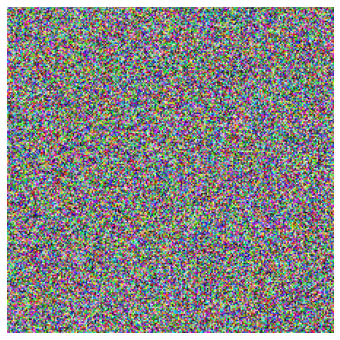

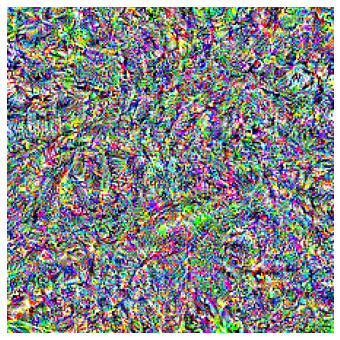

In [48]:
# optimize input img to maximally activate logit n of model
def superstimulate(img, model, n, steps=50):
    model.eval()
    img.train()
    optimizer = t.optim.Adam(img.parameters(), lr=0.05, maximize=True)
    for _ in range(steps):
        optimizer.zero_grad()
        activation = model(img())[0,n]
        activation.backward()
        optimizer.step()

img = Img()
imshow(img())
superstimulate(img, model, 50, steps=50)
imshow(img(), figsize=(6,6))

# Image parameterization 2

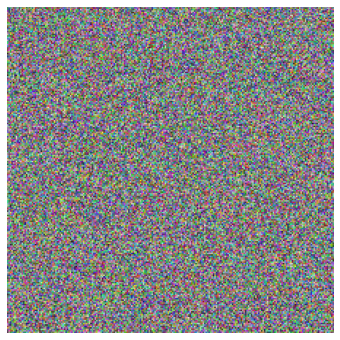

In [121]:
from torch.nn import Module, Parameter

class Img(Module):
    def __init__(self, C = 3, H=224, W=224):
        super().__init__()
        self.img = Parameter(t.randn(1, C, H, W))

    def forward(self):
        return self.img.sigmoid()
        
imshow(Img()(),figsize=(6,6))

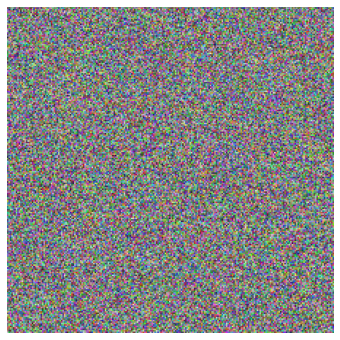

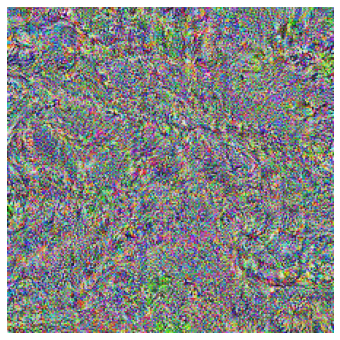

In [56]:
# superstimulate same as in part 1

img = Img()
imshow(img())
superstimulate(img, model, 50, steps=100)
imshow(img())

# Transformation robustness

In [4]:
import torchvision.transforms as transforms

perturb = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.05))
])

# optimize input img to maximally activate logit n of model
def superstimulate(img, model, n, lr=0.05, steps=50, pert=True):
    model.eval()
    img.train()
    optimizer = t.optim.Adam(img.parameters(), lr=lr, maximize=True)
    for _ in range(steps):
        optimizer.zero_grad()
        if pert:
            activation = model(perturb(img()))[0,n]
        else:
            activation = model(img())[0,n]
        activation.backward()
        optimizer.step()

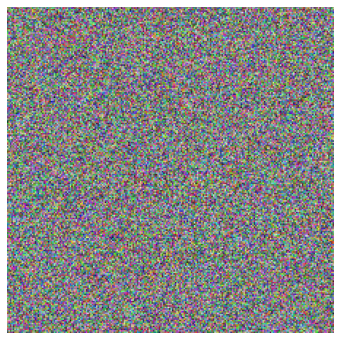

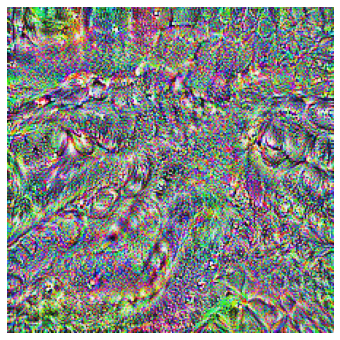

In [66]:
img = Img()
imshow(img())
superstimulate(img, model, 50, steps=500)
imshow(img())

# Image parameterization 3

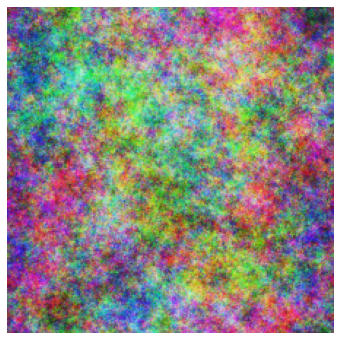

In [5]:
from torch.nn import Module, Parameter

class Img(Module):
    def __init__(self, scale=0.1, C = 3, H=224, W=224):
        super().__init__()
        self.scale = scale
        self.freq_coeffs = Parameter(t.randn(1, C, H, W//2+1, 2))
        fh, fw =  t.meshgrid(t.fft.fftfreq(H), t.fft.fftfreq(W)[:W//2 + 1], indexing='ij')
        freqs = (fh**2 + fw**2).sqrt()
        freqs[0,0] = 1/H
        self.register_buffer('freqs', freqs)

    def forward(self):
        pixels = t.fft.irfft2(t.view_as_complex(self.freq_coeffs) / self.freqs, norm="ortho")
        return (pixels * self.scale).sigmoid()
        
imshow(Img()(),figsize=(6,6))

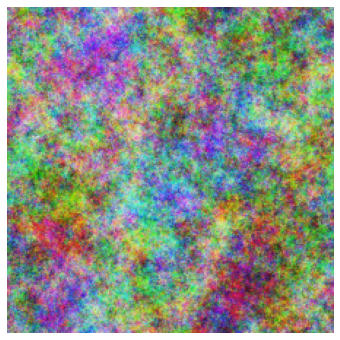

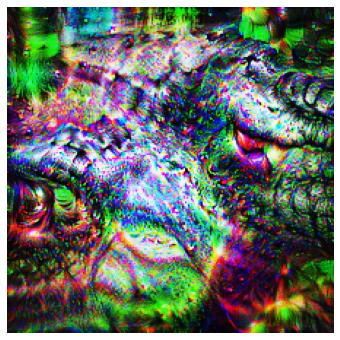

In [124]:
img = Img()
imshow(img())
superstimulate(img, model, 50, lr=0.1, steps=500)
imshow(img())

# Image parameterization 4

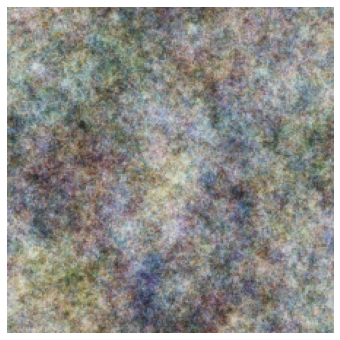

In [6]:
from torch.nn import Module, Parameter

# change of basis matrix from decorrelated basis to RGB basis
ChoB = t.Tensor(
    [[ 0.56282854,  0.19482528,  0.0432945],
     [ 0.5844758,   0.,         -0.10823626],
     [ 0.5844758,  -0.19482528,  0.06494176]]
)

class Img(Module):
    def __init__(self, scale = 0.1, C = 3, H=224, W=224):
        super().__init__()
        self.scale = scale
        self.freq_coeffs = Parameter(t.randn(1, C, H, W//2+1, 2))
        fh, fw =  t.meshgrid(t.fft.fftfreq(H), t.fft.fftfreq(W)[:W//2 + 1], indexing='ij')
        freqs = (fh**2 + fw**2).sqrt()
        freqs[0,0] = 1/H
        self.register_buffer('freqs', freqs)

    def forward(self):
        pixels = t.fft.irfft2(t.view_as_complex(self.freq_coeffs) / self.freqs, norm="ortho") * self.scale
        return t.einsum('ij, BjHW -> BiHW', ChoB, pixels).sigmoid()
        
imshow(Img(scale=.1)(),figsize=(6,6))

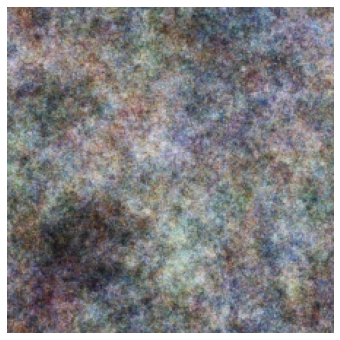

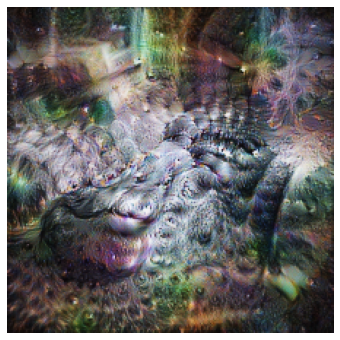

In [90]:
img = Img(scale=.1)
imshow(img())
superstimulate(img, model, 50, lr=0.05, steps=500)
imshow(img())

# Comparing parameterizations

In [118]:
# plot activations for feature n 
def plot_activations(n=50, lr=0.05, steps=200):
    img = Img()
    activations = []
    activations.append(model(img())[0,n])
    for _ in range(steps//10):
        superstimulate(img, model, n, lr=lr, steps=10)
        activations.append(model(img())[0,n])
    plt.plot(range(0,steps+1,10), t.Tensor(activations).detach())


You have to scroll up and run the implementation of Img corresponding to your desired paramterization before running plot_activations below, because that's a totally reasonable way to do this.

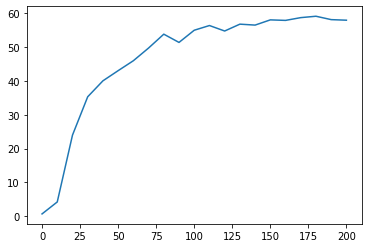

In [120]:
# Parameterization 1
plot_activations()

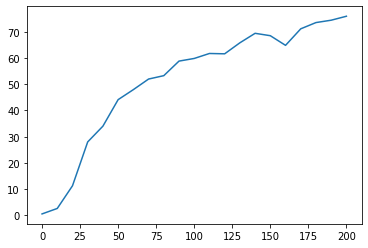

In [122]:
# Parameterization 2
plot_activations()

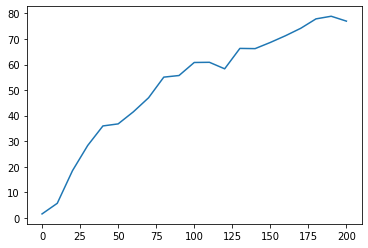

In [125]:
# Parameterization 3 (with scale=0.1)
plot_activations()


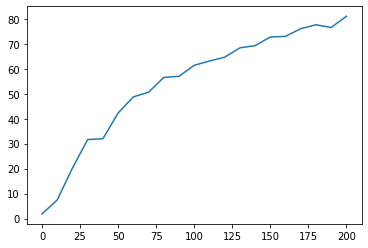

In [126]:
# Parameterization 4 (with scale=0.1)
plot_activations()

# One big run with lots of training steps

KeyboardInterrupt: 

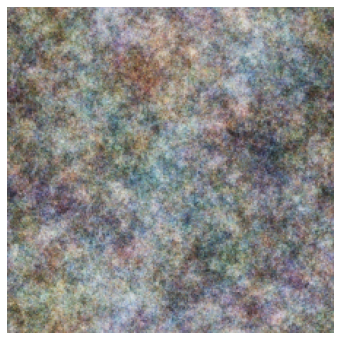

In [7]:
img = Img(scale=.1)
imshow(img())
superstimulate(img, model, 50, lr=0.05, steps=10000)
imshow(img())

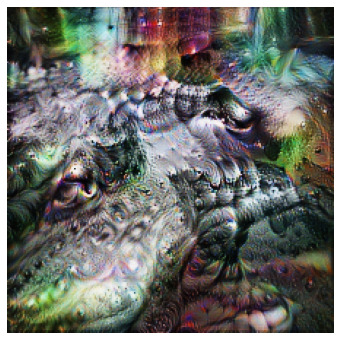

In [8]:
imshow(img())